In [17]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from sealsml.data import Preprocessor
import pandas as pd
from glob import glob
from numba import jit

In [4]:
ls /glade/derecho/scratch/dgagne/SEALS_output/train_20231206

model_2023-12-06_1600.keras      scaler_2023-12-06_1600.json
model_hist_2023-12-06_1600.nc    train_files.csv
model_output_2023-12-06_1600.nc  validation_files.csv


In [2]:
ls /glade/work/cbecker/SEALS_training_data/data_gen_20231214/

training_data_CBL2m_Ug10_src10kg_a.0.nc
training_data_CBL2m_Ug10_src10kg_a.1.nc
training_data_CBL2m_Ug10_src10kg_a.2.nc
training_data_CBL2m_Ug10_src10kg_a.3.nc
training_data_CBL2m_Ug10_src10kg_a.4.nc
training_data_CBL2m_Ug10_src10kg_a.5.nc
training_data_CBL2m_Ug10_src10kg_a.6.nc
training_data_CBL2m_Ug10_src10kg_a.7.nc
training_data_CBL2m_Ug10_src10kg_b.0.nc
training_data_CBL2m_Ug10_src10kg_b.1.nc
training_data_CBL2m_Ug10_src10kg_b.2.nc
training_data_CBL2m_Ug10_src10kg_b.3.nc
training_data_CBL2m_Ug10_src10kg_b.4.nc
training_data_CBL2m_Ug10_src10kg_b.5.nc
training_data_CBL2m_Ug10_src10kg_b.6.nc
training_data_CBL2m_Ug10_src10kg_b.7.nc
training_data_CBL2m_Ug10_src1-8kg_a.0.nc
training_data_CBL2m_Ug10_src1-8kg_a.1.nc
training_data_CBL2m_Ug10_src1-8kg_a.2.nc
training_data_CBL2m_Ug10_src1-8kg_a.3.nc
training_data_CBL2m_Ug10_src1-8kg_a.4.nc
training_data_CBL2m_Ug10_src1-8kg_a.5.nc
training_data_CBL2m_Ug10_src1-8kg_a.6.nc
training_data_CBL2m_Ug10_src1-8kg_a.7.nc
training_data_CBL2m_Ug10_src1-8k

In [3]:
ds = xr.open_dataset("/glade/work/cbecker/SEALS_training_data/data_gen_20231214/training_data_NBL2m_Ug2p5_src1-8kg_a.6.nc")

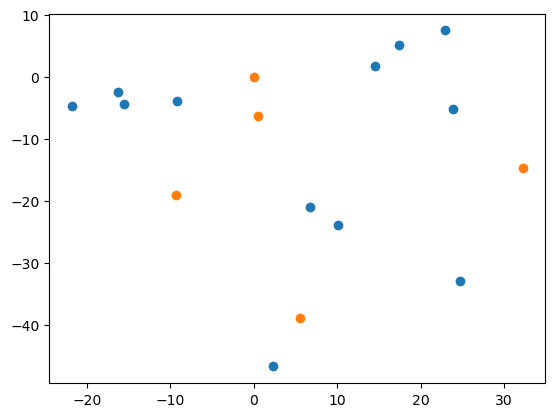

In [4]:
i = 2
mask = ds["decoder_input"][i, :, 0, 0, 1] == 0
plt.scatter(ds["decoder_input"][i, :, 0, 0, 0].values[mask] * ds["decoder_input"][i, :, 0, 2, 0].values[mask], 
           ds["decoder_input"][i, :, 0, 0, 0].values[mask] * ds["decoder_input"][i, :, 0, 1, 0].values[mask])
mask_en = ds["encoder_input"][i, :, 0, 0, 1] == 0
plt.scatter(ds["encoder_input"][i, :, 0, 0, 0].values[mask_en] * ds["encoder_input"][i, :, 0, 2, 0].values[mask_en], 
           ds["encoder_input"][i, :, 0, 0, 0].values[mask_en] * ds["encoder_input"][i, :, 0, 1, 0].values[mask_en])

In [38]:
t_files = sorted(glob("/glade/work/cbecker/SEALS_training_data/data_gen_20231214/*.nc"))
hist_bins = np.arange(-75, 85, 2)
methane_hist = np.zeros((hist_bins.size -1, hist_bins.size-1))
pot_leak_hist = np.zeros((hist_bins.size -1, hist_bins.size-1))
act_leak_hist = np.zeros((hist_bins.size -1, hist_bins.size-1))

for t_file in t_files:
    ds = xr.open_dataset(t_file)
    dmask = (ds["decoder_input"][:, :, 0, 0, 1] == 0) & (ds["target"][:, :, 0] == 0)
    dxs = ds["decoder_input"][:, :, 0, 0, 0].values[dmask] * ds["decoder_input"][:, :, 0, 2, 0].values[dmask]
    dys = ds["decoder_input"][:, :, 0, 0, 0].values[dmask] * ds["decoder_input"][:, :, 0, 1, 0].values[dmask]
    lmask = (ds["target"][:, :, 0] == 1)
    lxs = ds["decoder_input"][:, :, 0, 0, 0].values[lmask] * ds["decoder_input"][:, :, 0, 2, 0].values[lmask]
    lys = ds["decoder_input"][:, :, 0, 0, 0].values[lmask] * ds["decoder_input"][:, :, 0, 1, 0].values[lmask]
    emask = (ds["encoder_input"][:, :, 0, 7, 1] == 0)
    exs = ds["encoder_input"][:, :, 0, 0, 0].values[emask] * ds["encoder_input"][:, :, 0, 2, 0].values[emask]
    eys = ds["encoder_input"][:, :, 0, 0, 0].values[emask] * ds["encoder_input"][:, :, 0, 1, 0].values[emask]
    out = np.histogram2d(exs, eys, bins=hist_bins)
    methane_hist += out[0]
    out = np.histogram2d(dxs, dys, bins=hist_bins)
    pot_leak_hist += out[0]
    out = np.histogram2d(lxs, lys, bins=hist_bins)
    act_leak_hist += out[0]
    ds.close()

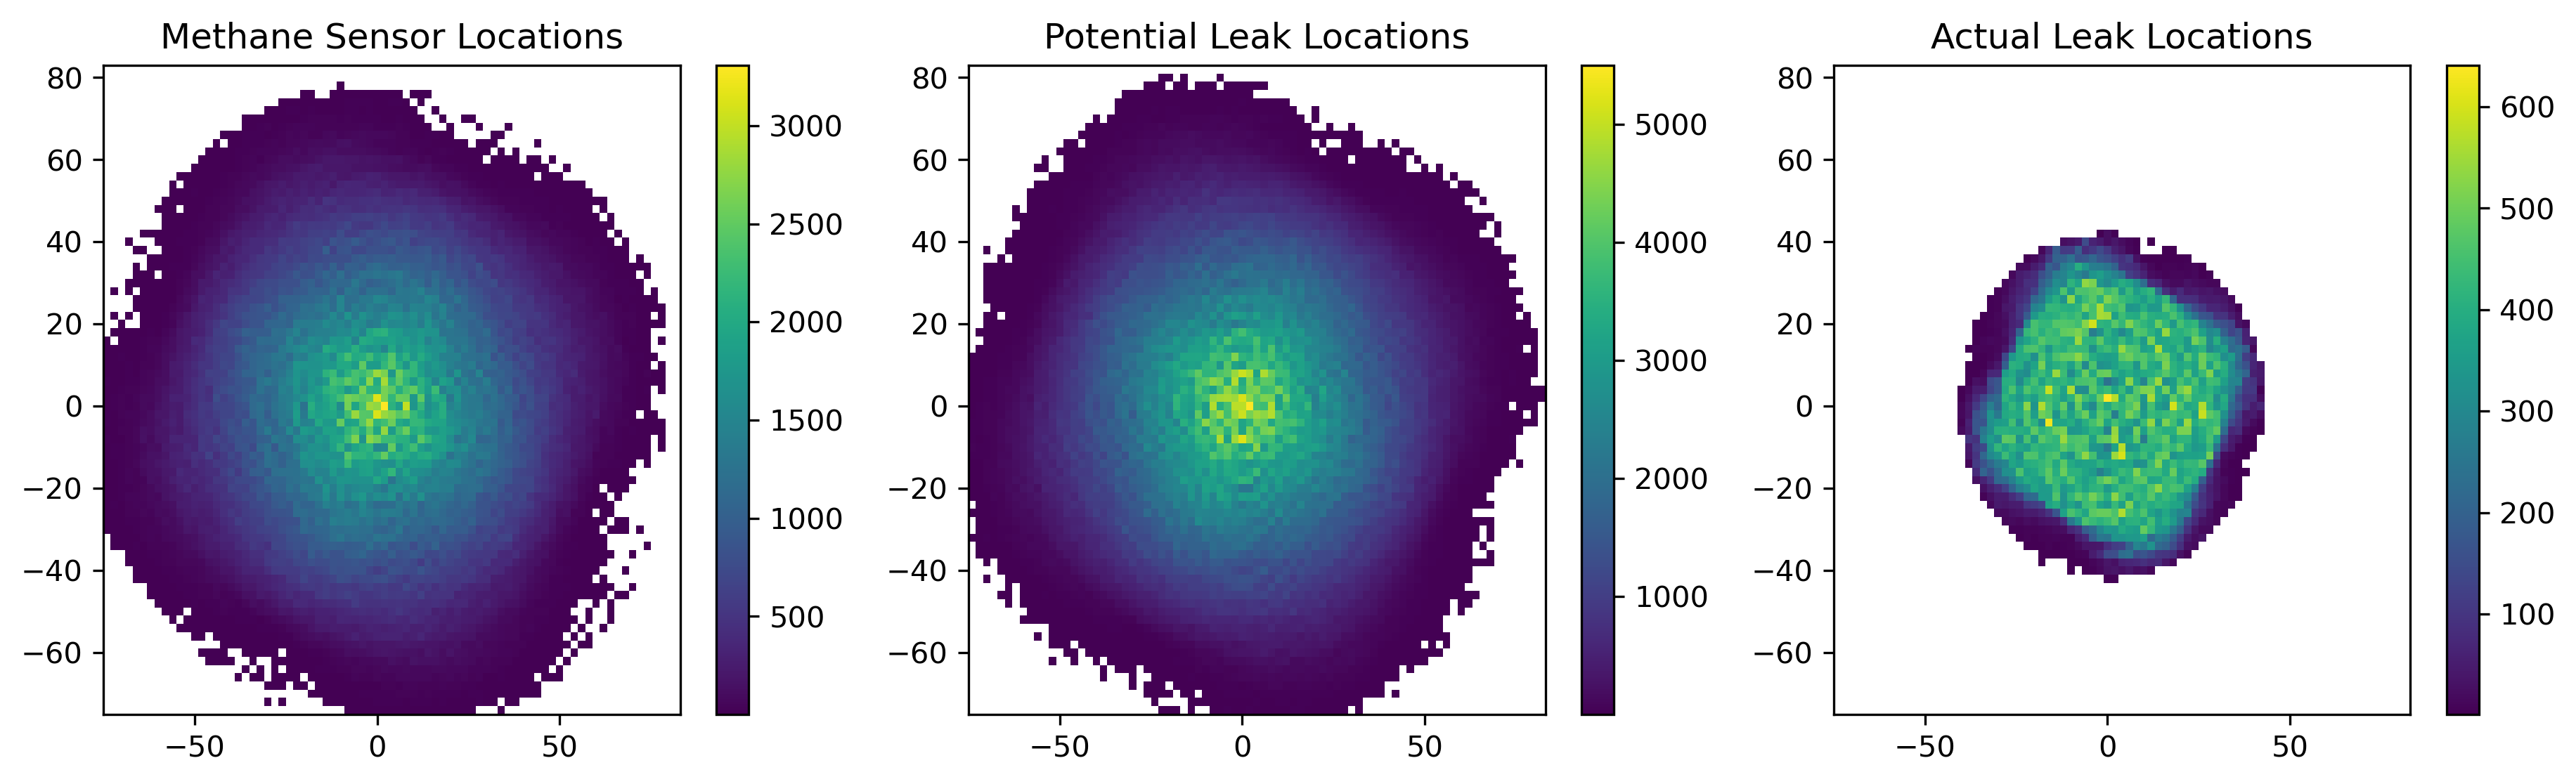

In [41]:
plt.figure(figsize=(15, 4), dpi=300)
plt.subplot(1, 3, 1)
_ = plt.pcolormesh(hist_bins, hist_bins, np.ma.array(methane_hist, mask=methane_hist==0))
plt.colorbar()
plt.title("Methane Sensor Locations")
plt.subplot(1, 3, 2)
_ = plt.pcolormesh(hist_bins, hist_bins, np.ma.array(pot_leak_hist, mask=pot_leak_hist==0))
plt.colorbar()
plt.title("Potential Leak Locations")
plt.subplot(1, 3, 3)
_ = plt.pcolormesh(hist_bins, hist_bins, np.ma.array(act_leak_hist, mask=act_leak_hist==0))
plt.colorbar()
plt.title("Actual Leak Locations")
plt.savefig("total_sampling_locations.png", dpi=300, bbox_inches="tight")

In [35]:
ds

<xarray.Dataset>
Dimensions:         (variable: 8, sample: 600, sensor: 10, time: 100, mask: 2,
                     pot_leak: 20, target_time: 1, sensor_loc: 3)
Coordinates:
  * variable        (variable) <U12 'ref_distance' 'ref_azi_sin' ... 'w' 'q_CH4'
  * sensor_loc      (sensor_loc) <U4 'xPos' 'yPos' 'zPos'
Dimensions without coordinates: sample, sensor, time, mask, pot_leak,
                                target_time
Data variables:
    encoder_input   (sample, sensor, time, variable, mask) float64 ...
    decoder_input   (sample, pot_leak, target_time, variable, mask) float64 ...
    target          (sample, pot_leak, target_time) float64 ...
    sensor_meta     (sample, sensor, sensor_loc) float64 ...
    leak_meta       (sample, pot_leak, sensor_loc) float64 ...
    met_sensor_loc  (sample, sensor_loc) float64 ...

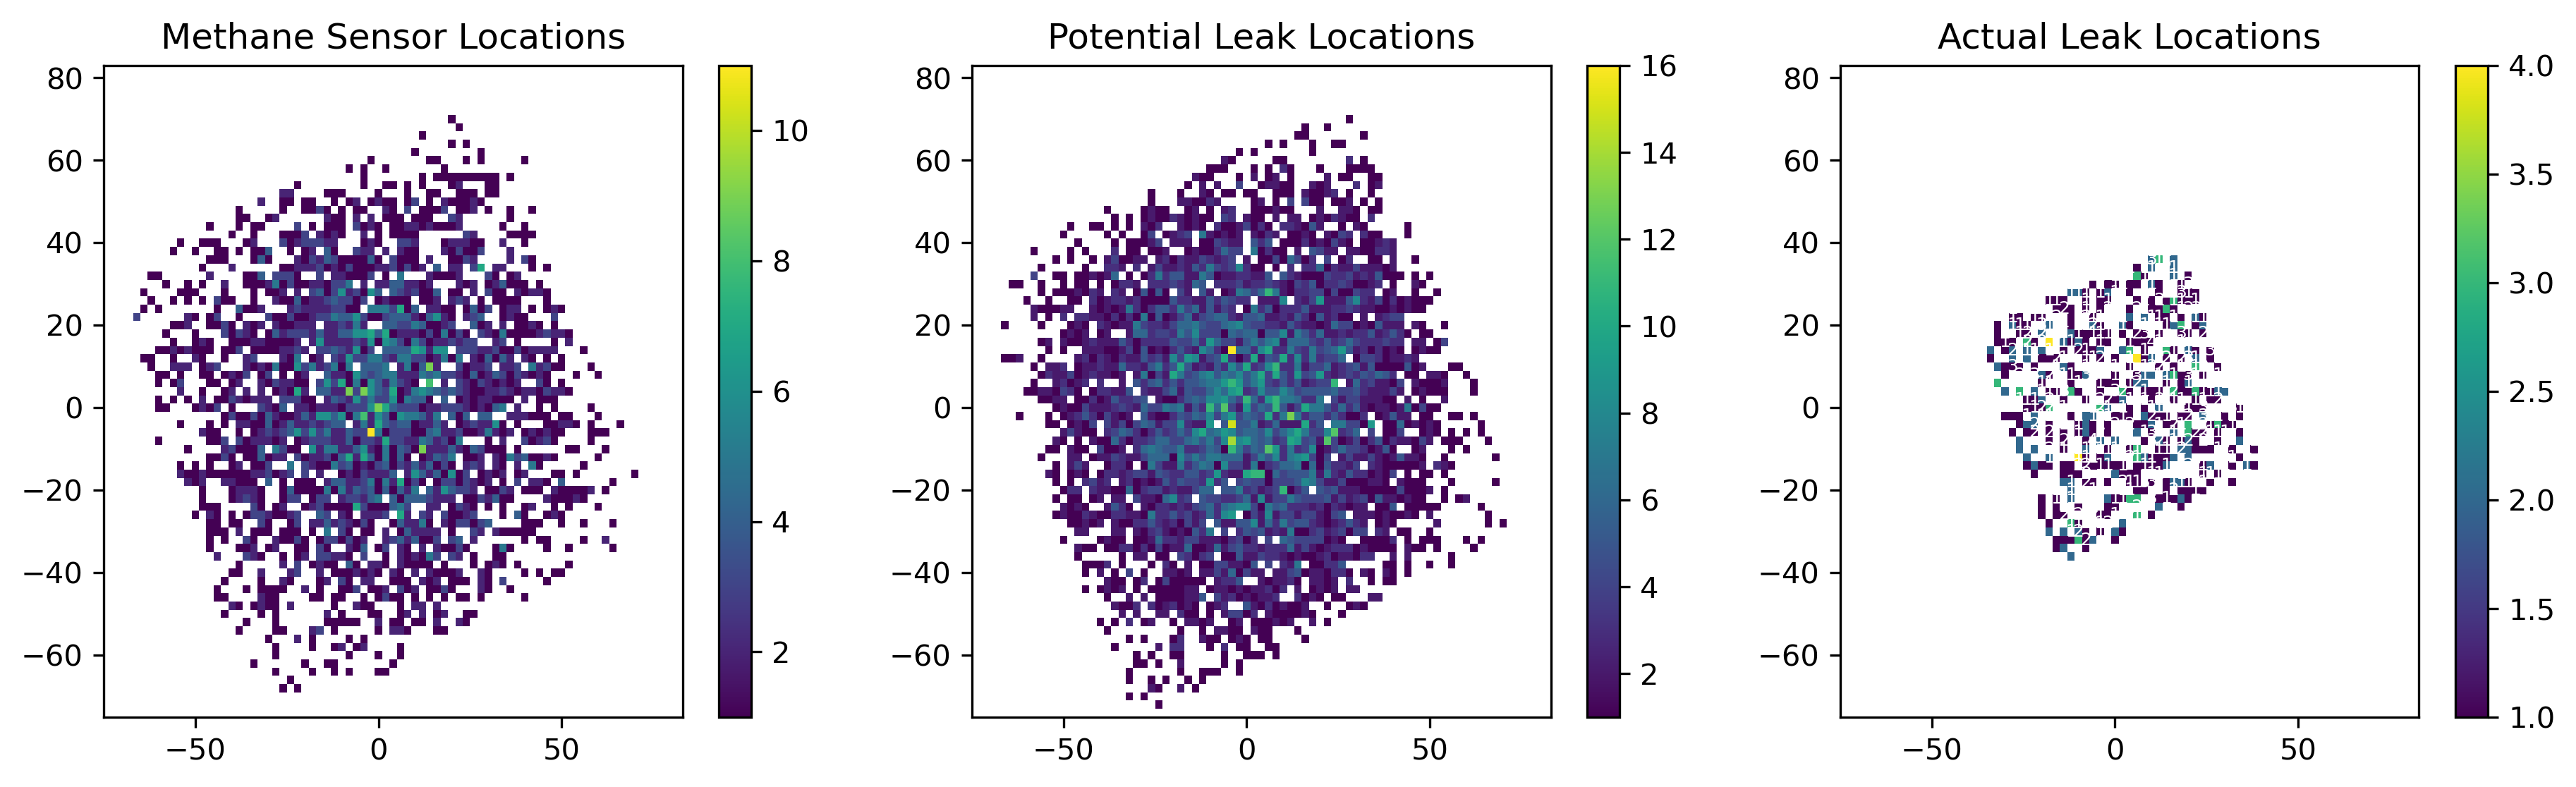

In [15]:
dmask = (ds["decoder_input"][:, :, 0, 0, 1] == 0) & (ds["target"][:, :, 0] == 0)
dxs = ds["decoder_input"][:, :, 0, 0, 0].values[dmask] * ds["decoder_input"][:, :, 0, 2, 0].values[dmask]
dys = ds["decoder_input"][:, :, 0, 0, 0].values[dmask] * ds["decoder_input"][:, :, 0, 1, 0].values[dmask]
lmask = (ds["target"][:, :, 0] == 1)
lxs = ds["decoder_input"][:, :, 0, 0, 0].values[lmask] * ds["decoder_input"][:, :, 0, 2, 0].values[lmask]
lys = ds["decoder_input"][:, :, 0, 0, 0].values[lmask] * ds["decoder_input"][:, :, 0, 1, 0].values[lmask]
emask = (ds["encoder_input"][:, :, 0, 7, 1] == 0)
exs = ds["encoder_input"][:, :, 0, 0, 0].values[emask] * ds["encoder_input"][:, :, 0, 2, 0].values[emask]
eys = ds["encoder_input"][:, :, 0, 0, 0].values[emask] * ds["encoder_input"][:, :, 0, 1, 0].values[emask]
plt.figure(figsize=(15, 4), dpi=300)
plt.subplot(1, 3, 1)
_ = plt.hist2d(exs, eys, cmin=1, bins=np.arange(-75, 85, 2))
plt.colorbar()
plt.title("Methane Sensor Locations")
plt.subplot(1, 3, 2)
_ = plt.hist2d(dxs, dys, cmin=1, bins=np.arange(-75, 85, 2))
plt.colorbar()
plt.title("Potential Leak Locations")
plt.subplot(1, 3, 3)
hout = plt.hist2d(lxs, lys, cmin=1, bins=np.arange(-75, 85, 2))
plt.colorbar()
plt.title("Actual Leak Locations")
for (i, j), val in np.ndenumerate(hout[0]):
    if ~np.isnan(val):
        plt.text(hout[2][i] + 5, hout[1][j] + 5, f"{val:0.0f}", fontsize=6, color='w', ha='center', va='center')
plt.savefig("sampling_locations.png", dpi=300, bbox_inches="tight")

(array([[  0.,   0.,   0.,   0.,   0.,  48., 137., 107., 122., 126., 103.,
         113.,  99., 132.,  41.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0., 125.,  87.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,  66., 140.,   0.,   0.,   0.,   0.],
        [  0.,   0.,  21., 163.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0., 134.,  28.,   0.,   0.],
        [  0.,   0., 128.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0., 140.,   0.,   0.],
        [  0., 125.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0., 127.,   0.],
        [ 46.,  72.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,  68.,  30.],
        [129.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 124.],
        [ 96.,   0.,   0., 

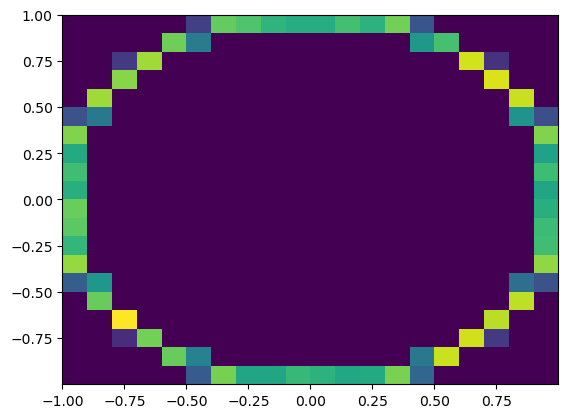

In [13]:
plt.hist2d(ds["decoder_input"][:, :, 0, 1, 0].values[dmask], ds["decoder_input"][:, :, 0, 2, 0].values[dmask], bins=20)

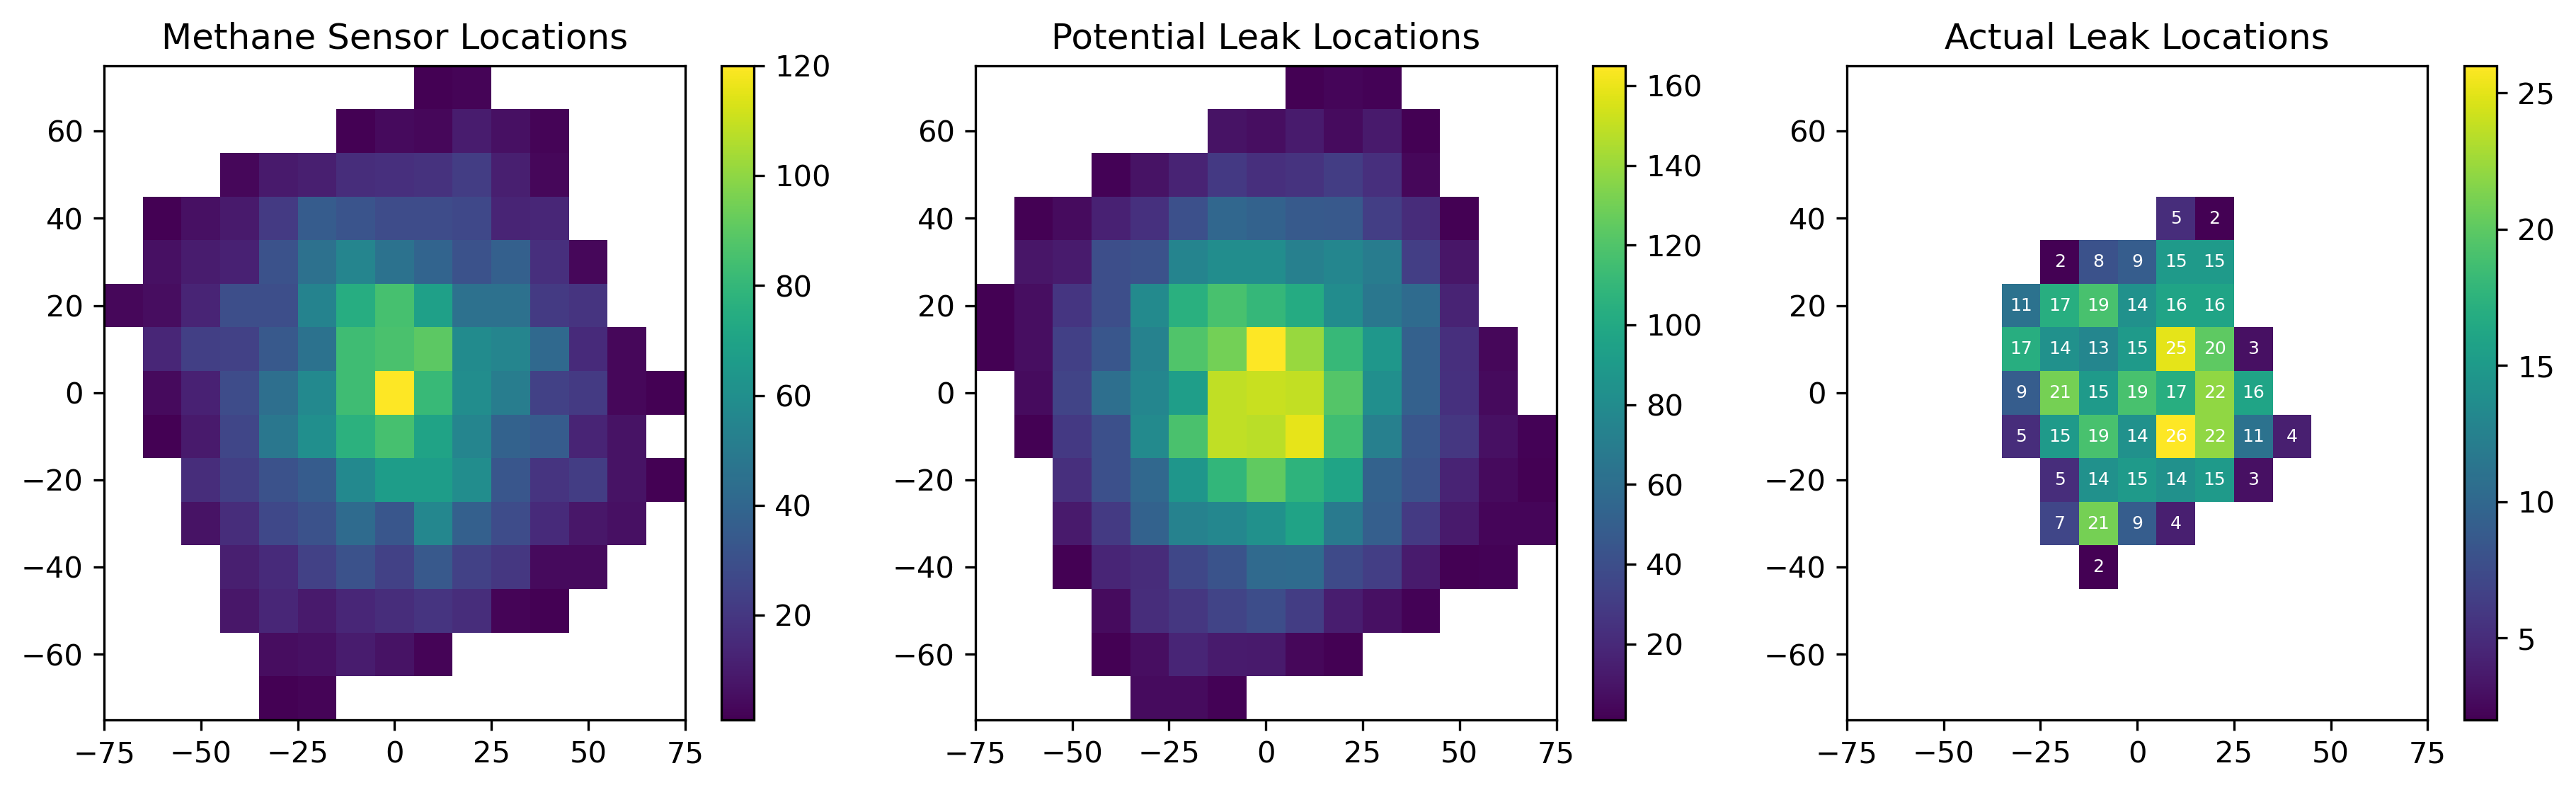

In [7]:
dmask = (ds["decoder_input"][:, :, 0, 0, 1] == 0) & (ds["target"][:, :, 0] == 0)
dxs = ds["decoder_input"][:, :, 0, 0, 0].values[dmask] * ds["decoder_input"][:, :, 0, 2, 0].values[dmask]
dys = ds["decoder_input"][:, :, 0, 0, 0].values[dmask] * ds["decoder_input"][:, :, 0, 1, 0].values[dmask]
lmask = (ds["target"][:, :, 0] == 1)
lxs = ds["decoder_input"][:, :, 0, 0, 0].values[lmask] * ds["decoder_input"][:, :, 0, 2, 0].values[lmask]
lys = ds["decoder_input"][:, :, 0, 0, 0].values[lmask] * ds["decoder_input"][:, :, 0, 1, 0].values[lmask]
emask = (ds["encoder_input"][:, :, 0, 7, 1] == 0)
exs = ds["encoder_input"][:, :, 0, 0, 0].values[emask] * ds["encoder_input"][:, :, 0, 2, 0].values[emask]
eys = ds["encoder_input"][:, :, 0, 0, 0].values[emask] * ds["encoder_input"][:, :, 0, 1, 0].values[emask]
plt.figure(figsize=(15, 4), dpi=300)
plt.subplot(1, 3, 1)
_ = plt.hist2d(exs, eys, cmin=1, bins=np.arange(-75, 85, 10))
plt.colorbar()
plt.title("Methane Sensor Locations")
plt.subplot(1, 3, 2)
_ = plt.hist2d(dxs, dys, cmin=1, bins=np.arange(-75, 85, 10))
plt.colorbar()
plt.title("Potential Leak Locations")
plt.subplot(1, 3, 3)
hout = plt.hist2d(lxs, lys, cmin=1, bins=np.arange(-75, 85, 10))
plt.colorbar()
plt.title("Actual Leak Locations")
for (i, j), val in np.ndenumerate(hout[0]):
    if ~np.isnan(val):
        plt.text(hout[2][i] + 5, hout[1][j] + 5, f"{val:0.0f}", fontsize=6, color='w', ha='center', va='center')
plt.savefig("sampling_locations.png", dpi=300, bbox_inches="tight")

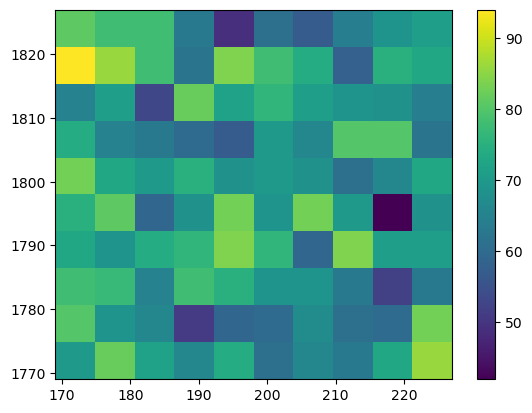

In [37]:
dmask = (ds["decoder_input"][:, :, 0, 0, 1] == 0) & (ds["target"][:, :, 0] == 0)
dxs = ds["leak_meta"][:, :, 0].values[dmask] 
dys = ds["leak_meta"][:, :, 1].values[dmask] 
plt.hist2d(dxs, dys, cmin=1)
plt.colorbar()

In [237]:
ds

<xarray.Dataset>
Dimensions:         (variable: 8, sample: 30, sensor: 10, time: 100, mask: 2,
                     pot_leak: 20, target_time: 1, sensor_loc: 3)
Coordinates:
  * variable        (variable) <U12 'ref_distance' 'ref_azi_sin' ... 'w' 'q_CH4'
  * sensor_loc      (sensor_loc) <U4 'xPos' 'yPos' 'zPos'
Dimensions without coordinates: sample, sensor, time, mask, pot_leak,
                                target_time
Data variables:
    encoder_input   (sample, sensor, time, variable, mask) float64 ...
    decoder_input   (sample, pot_leak, target_time, variable, mask) float64 ...
    target          (sample, pot_leak, target_time) float64 ...
    sensor_meta     (sample, sensor, sensor_loc) float64 ...
    leak_meta       (sample, pot_leak, sensor_loc) float64 ...
    met_sensor_loc  (sample, sensor_loc) float64 ...

(array([[40., 44., 46., 47., 48., 49., 48., 35., 47., 46.],
        [32., 43., 40., 31., 44., 70., 40., 55., 48., 43.],
        [43., 50., 47., 47., 45., 44., 48., 49., 45., 36.],
        [47., 44., 40., 32., 44., 43., 36., 46., 44., 49.],
        [43., 49., 34., 35., 36., 36., 44., 50., 45., 44.],
        [44., 39., 45., 49., 48., 50., 48., 41., 38., 64.],
        [53., 48., 50., 42., 56., 43., 48., 47., 52., 48.],
        [48., 42., 38., 37., 43., 39., 50., 36., 53., 38.],
        [41., 49., 42., 45., 60., 49., 48., 57., 48., 52.],
        [43., 46., 31., 39., 39., 45., 44., 47., 48., 47.]]),
 array([169. , 174.8, 180.6, 186.4, 192.2, 198. , 203.8, 209.6, 215.4,
        221.2, 227. ]),
 array([2369. , 2374.8, 2380.6, 2386.4, 2392.2, 2398. , 2403.8, 2409.6,
        2415.4, 2421.2, 2427. ]),
 <matplotlib.collections.QuadMesh at 0x14589173d810>)

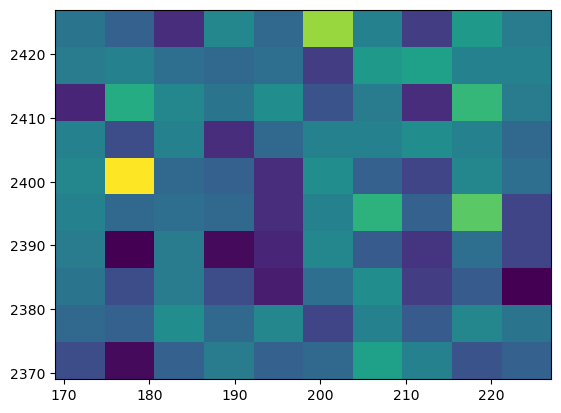

In [195]:
dmask = (ds["encoder_input"][:, :, 0, 0, 1] == 0)
dxs = ds["sensor_meta"][:, :, 0].values[dmask]
dys = ds["sensor_meta"][:, :, 1].values[dmask] 
plt.hist2d(dxs, dys, cmin=1)

In [201]:
ds["decoder_input"][:, :, 0, 0, 0].valuesds["met_sensor_loc"]

<xarray.DataArray 'met_sensor_loc' (sample: 600, sensor_loc: 3)>
[1800 values with dtype=float64]
Coordinates:
  * sensor_loc  (sensor_loc) <U4 'xPos' 'yPos' 'zPos'
Dimensions without coordinates: sample

(array([[ 6.,  8.,  8.,  4.,  6.,  4.,  4.,  6., 10.,  4.],
        [ 7.,  7.,  6.,  4.,  7., 14.,  8., 11.,  5.,  2.],
        [ 5.,  9.,  8.,  9.,  4.,  7.,  5.,  6.,  8.,  2.],
        [ 7.,  6.,  6.,  8.,  9.,  4.,  6.,  5.,  1.,  5.],
        [11.,  6.,  2.,  3.,  3.,  2.,  5.,  6.,  3., 10.],
        [ 5.,  4.,  7.,  4.,  5.,  5.,  6.,  4.,  4.,  6.],
        [ 6., 10.,  6.,  3.,  9.,  4.,  8.,  5.,  5.,  6.],
        [ 7.,  9.,  5.,  8.,  9.,  3.,  3.,  2.,  6., 10.],
        [ 8.,  7.,  8.,  5.,  9.,  7.,  4.,  8.,  3.,  6.],
        [ 6.,  7.,  9.,  5.,  4.,  6.,  2.,  9.,  7.,  4.]]),
 array([169. , 174.8, 180.6, 186.4, 192.2, 198. , 203.8, 209.6, 215.4,
        221.2, 227. ]),
 array([2369. , 2374.8, 2380.6, 2386.4, 2392.2, 2398. , 2403.8, 2409.6,
        2415.4, 2421.2, 2427. ]),
 <matplotlib.collections.QuadMesh at 0x14589080f310>)

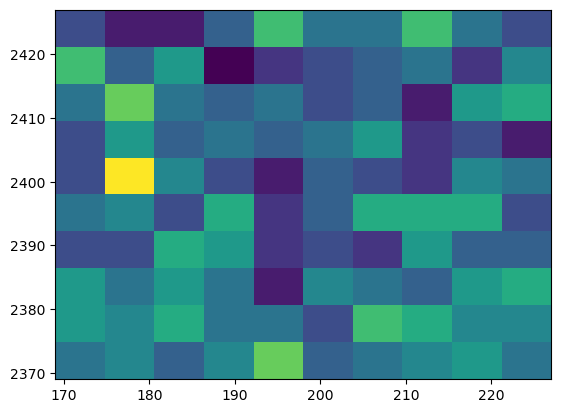

In [187]:
plt.hist2d(ds["met_sensor_loc"][:, 0], ds["met_sensor_loc"][:, 1])

(array([[505., 495., 476., 545., 501., 530., 508., 522., 529., 505.],
        [510., 486., 528., 519., 513., 515., 493., 458., 480., 494.],
        [472., 501., 506., 472., 484., 505., 494., 522., 484., 498.],
        [507., 576., 547., 488., 472., 464., 501., 549., 523., 485.],
        [499., 514., 545., 490., 511., 503., 481., 484., 536., 525.],
        [531., 465., 531., 503., 509., 507., 467., 488., 477., 486.],
        [523., 495., 485., 473., 470., 458., 509., 494., 473., 479.],
        [523., 482., 491., 500., 508., 542., 511., 507., 482., 491.],
        [489., 503., 477., 485., 513., 527., 469., 522., 488., 487.],
        [492., 502., 516., 465., 486., 472., 509., 524., 452., 512.]]),
 array([ 0. ,  2.9,  5.8,  8.7, 11.6, 14.5, 17.4, 20.3, 23.2, 26.1, 29. ]),
 array([ 0. ,  2.9,  5.8,  8.7, 11.6, 14.5, 17.4, 20.3, 23.2, 26.1, 29. ]),
 <matplotlib.collections.QuadMesh at 0x145890e9d000>)

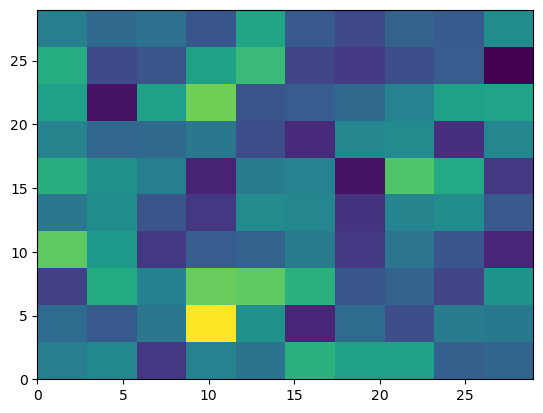

In [180]:
rand_xs = np.random.randint(0, 30, 50000)
rand_ys = np.random.randint(0, 30, 50000)
plt.hist2d(rand_xs, rand_ys)

In [164]:
ds["met_sensor_loc"]

<xarray.DataArray 'met_sensor_loc' (sample: 600, sensor_loc: 3)>
[1800 values with dtype=float64]
Coordinates:
  * sensor_loc  (sensor_loc) <U4 'xPos' 'yPos' 'zPos'
Dimensions without coordinates: sample

In [150]:
ds["encoder_input"][0, :, 0, 7, 1].values

array([-999.,    0.,    0.,    0.,    0.,    0.,   -1.,   -1.,   -1.,
         -1.])

In [144]:
ds["decoder_input"][:, :, 0, 0, 0].values[ds["target"][:, :, 0] == 1]

(600,)

In [ ]:

plt.hist2d(

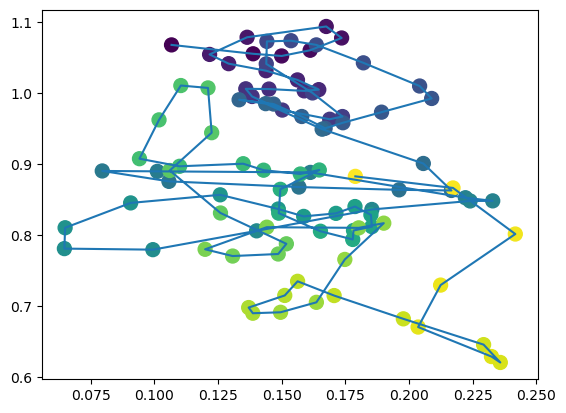

In [107]:
plt.scatter(ds["encoder_input"][i, 0, :, 4, 0].values.T, ds["encoder_input"][i, 0, :, 5, 0].values.T, 100, np.arange(100))
plt.plot(ds["encoder_input"][i, 0, :, 4, 0].values.T, ds["encoder_input"][i, 0, :, 5, 0].values.T)


In [88]:
ds["encoder_input"][i, :, 0, 0, 1].values

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1., -1.])

In [62]:
ds["encoder_input"][i, :, :, 4, 0]

<xarray.DataArray 'encoder_input' (sensor: 10, time: 100)>
[1000 values with dtype=float64]
Coordinates:
    variable  <U12 'u'
Dimensions without coordinates: sensor, time

In [50]:
ds["encoder_input"][0, :, -1, :, 1].values

array([[   0.,    0.,    0.,    0.,    0.,    0.,    0., -999.],
       [   0.,    0.,    0.,    0., -999., -999., -999.,    0.],
       [   0.,    0.,    0.,    0., -999., -999., -999.,    0.],
       [   0.,    0.,    0.,    0., -999., -999., -999.,    0.],
       [   0.,    0.,    0.,    0., -999., -999., -999.,    0.],
       [   0.,    0.,    0.,    0., -999., -999., -999.,    0.],
       [  -1.,   -1.,   -1.,   -1.,   -1.,   -1.,   -1.,   -1.],
       [  -1.,   -1.,   -1.,   -1.,   -1.,   -1.,   -1.,   -1.],
       [  -1.,   -1.,   -1.,   -1.,   -1.,   -1.,   -1.,   -1.],
       [  -1.,   -1.,   -1.,   -1.,   -1.,   -1.,   -1.,   -1.]])

In [47]:
ds["encoder_input"]

<xarray.DataArray 'encoder_input' (sample: 600, sensor: 10, time: 100,
                                   variable: 8, mask: 2)>
[9600000 values with dtype=float64]
Coordinates:
  * variable  (variable) <U12 'ref_distance' 'ref_azi_sin' ... 'w' 'q_CH4'
Dimensions without coordinates: sample, sensor, time, mask

In [28]:
ds["target"][0].values.ravel()

array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])

In [3]:
d = pd.read_csv("/glade/derecho/scratch/dgagne/SEALS_output/train_20231206/validation_files.csv")

In [6]:
d['validation_files'].values

array(['/glade/derecho/scratch/dgagne/SEALS_training_data_20231206/training_data_NBL2m_Ug2p5_src10kg_a.6.nc',
       '/glade/derecho/scratch/dgagne/SEALS_training_data_20231206/training_data_NBL2m_Ug10_src1-8kg_b.2.nc',
       '/glade/derecho/scratch/dgagne/SEALS_training_data_20231206/training_data_CBL2m_Ug3p6_src10kg_b.1.nc',
       '/glade/derecho/scratch/dgagne/SEALS_training_data_20231206/training_data_DC_Ug15_src_9_10kg_hour_01.6.nc',
       '/glade/derecho/scratch/dgagne/SEALS_training_data_20231206/training_data_FE_NBL2m_Ug10_src1-8kg_a.3.nc',
       '/glade/derecho/scratch/dgagne/SEALS_training_data_20231206/training_data_CBL2m_Ug5_src1-8kg_a.6.nc',
       '/glade/derecho/scratch/dgagne/SEALS_training_data_20231206/training_data_CBL2m_Ug10_src10kg_a.4.nc',
       '/glade/derecho/scratch/dgagne/SEALS_training_data_20231206/training_data_CBL2m_Ug5_src10kg_a.2.nc',
       '/glade/derecho/scratch/dgagne/SEALS_training_data_20231206/training_data_CBL2m_Ug3p6_src1-8kg_b.4.nc',
     

In [7]:
pre = Preprocessor()
val_encoder, val_decoder, targets = pre.load_data(d["validation_files"].values)

In [15]:
hist = pd.read_csv("/glade/derecho/scratch/dgagne/SEALS_output/train_20231206/model_hist_2023-12-06_1600.nc")

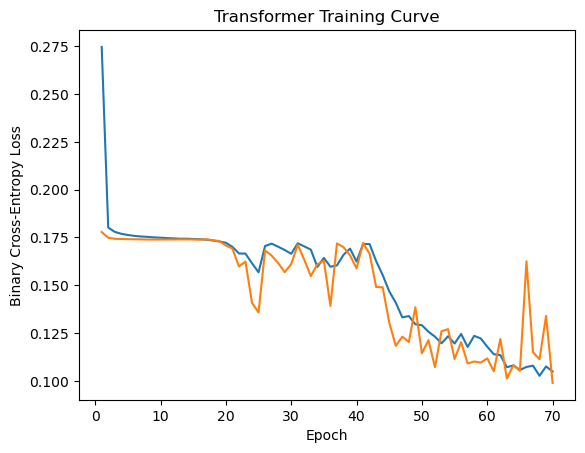

In [142]:
plt.plot(np.arange(1, 71), hist["loss"])
plt.plot(np.arange(1, 71), hist["val_loss"])
plt.xlabel("Epoch")
plt.ylabel("Binary Cross-Entropy Loss")
plt.title("Transformer Training Curve")
plt.savefig("training_curve.png", dpi=300, bbox_inches="tight")

In [20]:
pred_ds = xr.open_dataset("/glade/derecho/scratch/dgagne/SEALS_output/train_20231206/model_output_2023-12-06_1600.nc")

In [22]:
pred_ds["probabilities"]

<xarray.DataArray 'probabilities' (sample: 15000, pot_leak_locs: 20)>
[300000 values with dtype=float32]
Dimensions without coordinates: sample, pot_leak_locs

In [34]:
val_decoder[0, :, 0, 0, 0].values

array([ 2.62078784e+03,  2.59449487e+03,  2.61419312e+03,  2.58614111e+03,
        2.61663208e+03,  2.57159644e+03,  2.59753369e+03,  2.60049072e+03,
        2.61199438e+03,  2.60619775e+03,  2.58849927e+03,  2.57934375e+03,
        2.61833130e+03,  2.57734595e+03,  2.61392993e+03,  2.59315039e+03,
        2.57982275e+03,  2.59187842e+03,  2.61912549e+03, -1.00000000e+00])

(15000, 20, 1, 8, 2)

In [36]:
val_decoder["variable"]

<xarray.DataArray 'variable' (variable: 8)>
array(['ref_distance', 'ref_azi_sin', 'ref_azi_cos', 'ref_elv', 'u', 'v', 'w',
       'q_CH4'], dtype='<U12')
Coordinates:
  * variable  (variable) <U12 'ref_distance' 'ref_azi_sin' ... 'w' 'q_CH4'

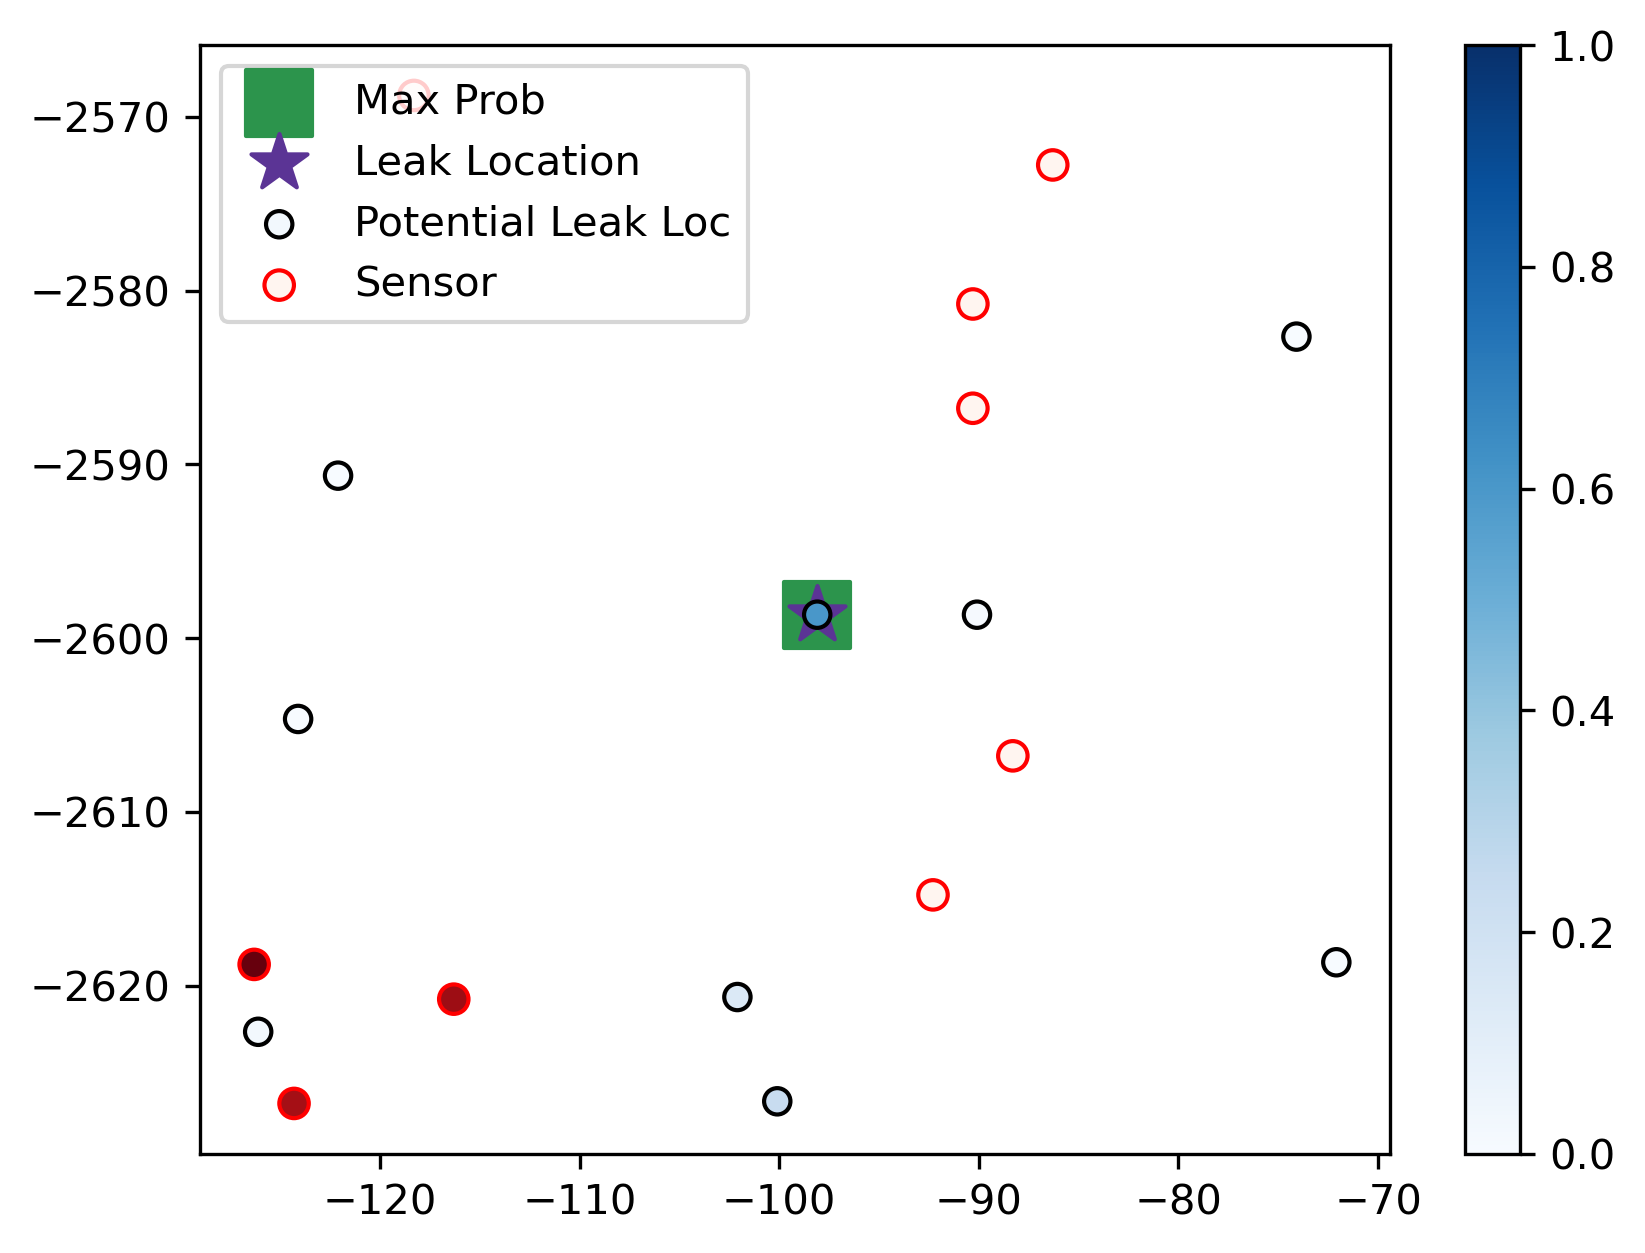

In [144]:
plt.figure(dpi=300)
idx = 356
mask = val_decoder[idx, :, 0, 0, 1].values > -1
r = val_decoder[idx, :, 0, 0, 0].values[mask]
az_sin = val_decoder[idx, :, 0, 1, 0].values[mask]
az_cos = val_decoder[idx, :, 0, 2, 0].values[mask]
x = r * az_cos
y = r * az_sin
t = targets[idx].argmax()
p_max = pred_ds["probabilities"].values[idx][mask].argmax()
plt.scatter(x[p_max], y[p_max], 250, 1, marker='s', vmin=0, vmax=1.4, cmap="Greens", label="Max Prob") 
plt.scatter(x[t], y[t], 200, 1, marker='*', vmin=0, vmax=1.2, cmap="Purples", label="Leak Location")

plt.scatter(x, y, 40, pred_ds["probabilities"].values[idx][mask], cmap="Blues", vmin=0, vmax=1, edgecolor='k', label="Potential Leak Loc")
plt.colorbar()
s_mask = val_encoder[idx, :, 0, 0, 1].values > -1
s_r = val_encoder[idx, :, 0, 0, 0].values[s_mask]
s_az_sin = val_encoder[idx, :, 0, 1, 0].values[s_mask]
s_az_cos = val_encoder[idx, :, 0, 2, 0].values[s_mask]
s_x = s_r * s_az_cos
s_y = s_r * s_az_sin
max_ch4 = val_encoder[idx, :, :, -1, 0].max(axis=-1)
plt.scatter(s_x, s_y, 50, np.log10(max_ch4[s_mask]), edgecolor='red', cmap="Reds", label="Sensor")
plt.legend(fontsize=10)
plt.savefig("transformer_test_example.png", dpi=300, bbox_inches="tight")

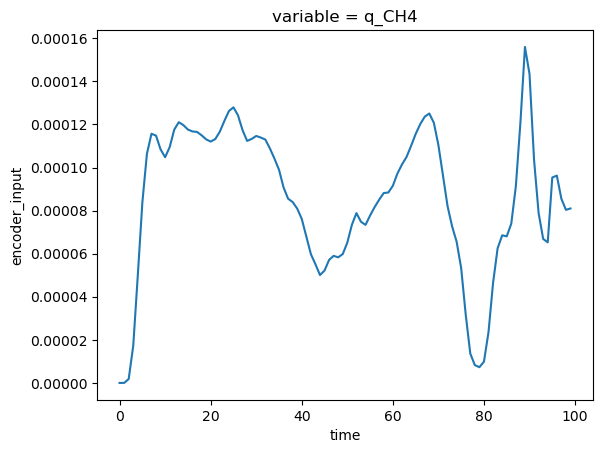

In [123]:
val_encoder[idx, 0, :, -1, 0].plot()

In [126]:
val_encoder[idx, :, :, -1, 0].max(axis=-1)

<xarray.DataArray 'encoder_input' (sensor: 10)>
dask.array<_nanmax_skip-aggregate, shape=(10,), dtype=float64, chunksize=(10,), chunktype=numpy.ndarray>
Coordinates:
    variable  <U12 'q_CH4'
Dimensions without coordinates: sensor

In [83]:
pred_ds["probabilities"].values[idx]

array([1.56143345e-02, 1.57438189e-01, 5.88174701e-01, 1.78029411e-04,
       1.75790906e-01, 1.22181863e-01, 5.70282509e-07, 5.70282509e-07,
       5.70282509e-07, 5.70282509e-07, 5.70282509e-07, 5.70282509e-07,
       5.70282509e-07, 5.70282509e-07, 5.70282509e-07, 5.70282509e-07,
       5.70282509e-07, 5.70282509e-07, 5.70282509e-07, 5.70282509e-07],
      dtype=float32)

In [218]:
theta_wd = np.radians(90)
x_target = 30.
y_target = 25.
x_ref = 40
y_ref = 50
x_relative = x_ref - x_target
y_relative = y_ref - y_target
x_rotated = x_relative * np.cos(theta_wd) - y_relative * np.sin(theta_wd)
y_rotated = x_relative * np.sin(theta_wd) + y_relative * np.cos(theta_wd)
print(x_rotated, y_rotated)
theta = np.arctan2(y_rotated, x_rotated)
print(np.degrees(theta))

-25.0 10.000000000000002
158.19859051364818


In [219]:
theta_wd = np.radians(90)
x_target = 30.
y_target = 25.
x_ref = 40
y_ref = 50
x_relative = x_target - x_ref
y_relative = y_target - y_ref
x_rotated = x_relative * np.cos(theta_wd) - y_relative * np.sin(theta_wd)
y_rotated = x_relative * np.sin(theta_wd) + y_relative * np.cos(theta_wd)
print(x_rotated, y_rotated)
theta = np.arctan2(y_rotated, x_rotated)
print(np.degrees(theta))

25.0 -10.000000000000002
-21.801409486351815


-0.9335998541643669
